In [1]:
import pandas as pd
import numpy as np
import os
import numpy as np
import nibabel as nib
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
from dipy.data.fetcher import fetch_syn_data, read_syn_data
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
import pickle


### load patient info ###

info = pd.read_csv('S:\\Usyd\\Project\\Data\\info2.csv',index_col = 0)

labelsDict = {}
ijkDict = {}
proscenDict = {}
patientcase = {}
for i in range (1,len(info)+1):
    labels = info.get_value(i,'label')
    ijk = info.get_value(i, 'ijk')
    patient_id = info.get_value(i, 'pt_id')
    proscen = info.get_value(i, 'pros_cen')
#    print(patient_id)
#    print(labels)
#    print('Tumour location:', ijk)
#    print('Prostate center location:', proscen)
    patientcase[i] = patient_id
    labelsDict[i] = labels
    ijkDict[i] = ijk
    proscenDict[i] = proscen
    
labels = []
for i in labelsDict:
    labels += [labelsDict[i]]
    
case = []
for i in patientcase:
    case += [patientcase[i]]
    
ijk = []
for i in ijkDict:
    ijk += [ijkDict[i]]

proscen = []
for i in proscenDict:
    proscen += [proscenDict[i]]
    
print('All the relevant info has been loaded')

D:\Anaconda_3\lib\site-packages\dipy\viz\__init__.py:22: UserWarning: You do not have FURY installed. Some visualization functions might not work for you. For installation instructions, please visit: https://fury.gl/
  "You do not have FURY installed. "


All the relevant info has been loaded


D:\Anaconda_3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
D:\Anaconda_3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
D:\Anaconda_3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
D:\Anaconda_3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [2]:
### get the x,y,z coordinates of the tumour and prostate center ###
### check for the distance in x,y,z between prostate center and tumour ###
x= [None] * len (ijk)
y= [None] * len (ijk)
z= [None] * len (ijk)
X= [None] * len (ijk)
Y= [None] * len (ijk)
Z= [None] * len (ijk)
for i in range(0, len(ijk)):
    a = ijk[i].split()
    x[i] = a[0]          # tumour x-coordinate
    y[i] = a[1]          # tumour y-coordinate
    z[i] = a[2]          # tumour z-coordinate
for i in range(0, len(ijk)):
    b = proscen[i].split()
    X[i] = b[0]          # prostate center x-coordinate
    Y[i] = b[1]          # prostate center y-coordinate
    Z[i] = b[2]          # prostate center z-coordinate
    

### convert string into int ###    
x = [int(i) for i in x]
y = [int(i) for i in y]
z = [int(i) for i in z] 
X = [int(i) for i in X] 
Y = [int(i) for i in Y] 
Z = [int(i) for i in Z] 

### find the maximum distance between prostate center and tumour ###
xx = np.array(x)
yy = np.array(y)
zz = np.array(z)
XX = np.array(X)
YY = np.array(Y)
ZZ = np.array(Z)
xdiff = abs(xx.astype(np.int) - XX.astype(np.int))
ydiff = abs(yy.astype(np.int) - YY.astype(np.int))
zdiff = abs(zz.astype(np.int) - ZZ.astype(np.int))
print('The maximum distance between the prostate center and tumour is:', max(xdiff), 'in x-direction and', max(ydiff), 'in y-direction.')

The maximum distance between the prostate center and tumour is: 65 in x-direction and 73 in y-direction.


In [3]:
### Load input images ###
### Image Re-sample so that they all have the same dimension of t2w,adc and ktrans ###

stack=[]
for i in case[261:]:
    directory = "S:\\Usyd\\Project\\Data\\mri\\" + i
    print(directory)
    s = os.listdir(directory)
    t2w = nib.load("S:\\Usyd\\Project\\Data\\mri\\" + i +"\\" + s[2])
    adc = nib.load("S:\\Usyd\\Project\\Data\\mri\\" + i +"\\" + s[0])
    ktrans = nib.load("S:\\Usyd\\Project\\Data\\mri\\" + i +"\\" + s[1])
    
    static = t2w.get_data()
    static_grid2world = t2w.affine
    moving = adc.get_data()
    moving_grid2world = adc.affine
    moving2 = ktrans.get_data()
    moving2_grid2world = ktrans.affine
    identity = np.eye(4)
    affine_map = AffineMap(identity, static.shape, static_grid2world, moving.shape, moving_grid2world)
    resample1 = affine_map.transform(moving)
    affine_map2 = AffineMap(identity, static.shape, static_grid2world, moving2.shape, moving2_grid2world)
    resample2 = affine_map2.transform(moving2)
    output = np.stack([static.transpose(2,1,0),resample1.transpose (2,1,0), resample2.transpose(2,1,0)], axis = -1)
    print(output.shape)
    patient = output
    stack += [patient]

S:\Usyd\Project\Data\mri\pt_0167
(21, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0168
(19, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0169
(23, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0170
(19, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0170
(19, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0171
(23, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0171
(23, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0171
(23, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0172
(21, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0172
(21, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0172
(21, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0173
(21, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0173
(21, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0174
(19, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0175
(21, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0175
(21, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0176
(21, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0176
(21, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_0177
(19, 384, 384, 3)
S:\Usyd\Project\Data\mri\pt_017

In [5]:
### Crop the images into size 224 x 224 ###
### Normalise the image values into [0,1] ###
import copy 
cstack=[]
sstack = copy.deepcopy(stack)
for j in range (len(sstack)):
    cpatient = sstack[j][Z[j+261],Y[j+261]-112:Y[j+261]+112,X[j+261]-112:X[j+261]+112,:]      # Note that coordinates order: [slice,y,x,z]
    cstack += [cpatient]
for i in range (len(cstack)):
    cstack[i][:,:,0]=np.true_divide(cstack[i][:,:,0] - np.amin(cstack[i][:,:,0]),np.amax(cstack[i][:,:,0]) - np.amin(cstack[i][:,:,0]))
    cstack[i][:,:,1]=np.true_divide(cstack[i][:,:,1] - np.amin(cstack[i][:,:,1]),np.amax(cstack[i][:,:,1]) - np.amin(cstack[i][:,:,1]))
    cstack[i][:,:,2]=np.true_divide(cstack[i][:,:,2] - np.amin(cstack[i][:,:,2]),np.amax(cstack[i][:,:,2]) - np.amin(cstack[i][:,:,2]))
cstack = np.nan_to_num(cstack)

In [6]:
cstack.shape

(65, 224, 224, 3)

In [20]:
proscen[58]

'186 209 7'

Finding  261
pt_0167
Tumour location: 189 156 3
Prostate center: 184 172 3
The finding is:  False


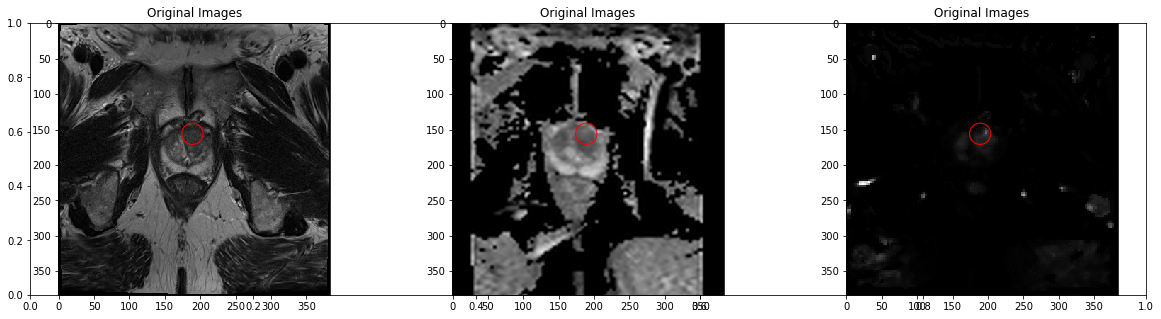

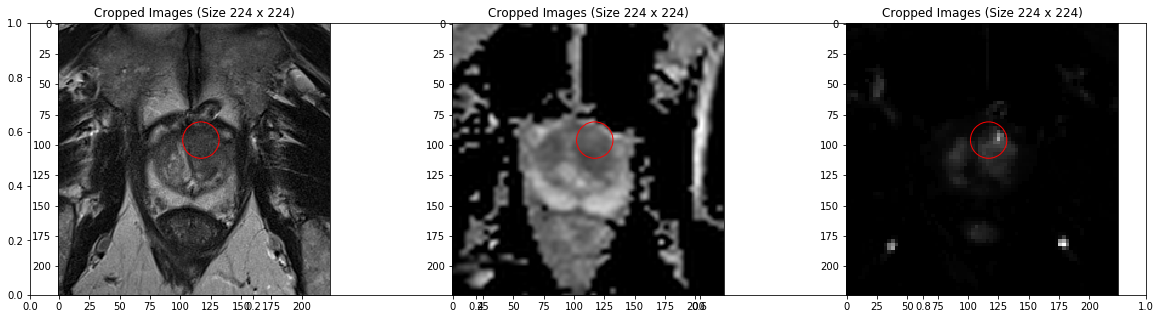

Finding  262
pt_0168
Tumour location: 170 204 6
Prostate center: 192 200 6
The finding is:  False


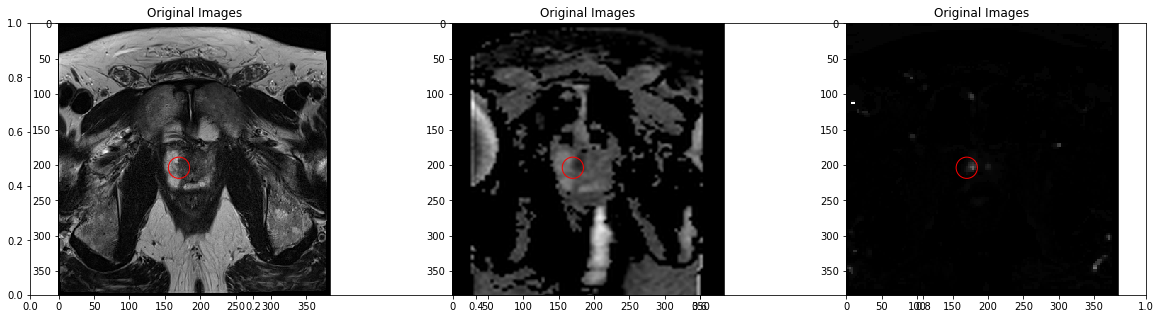

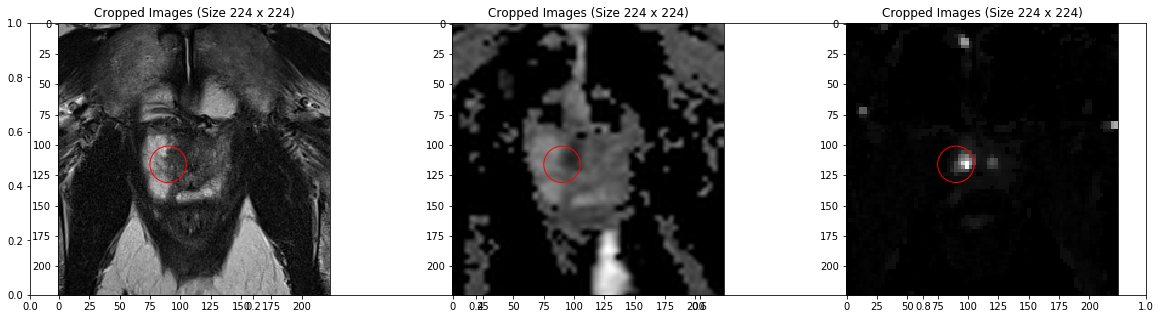

Finding  263
pt_0169
Tumour location: 200 207 11
Prostate center: 192 200 11
The finding is:  True


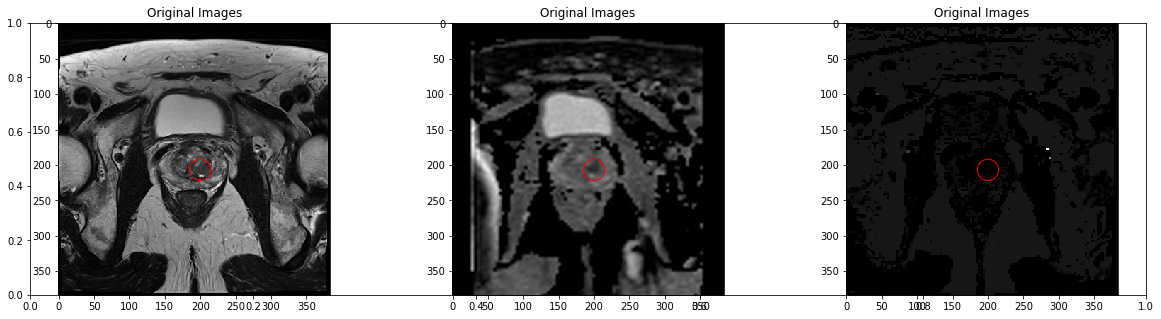

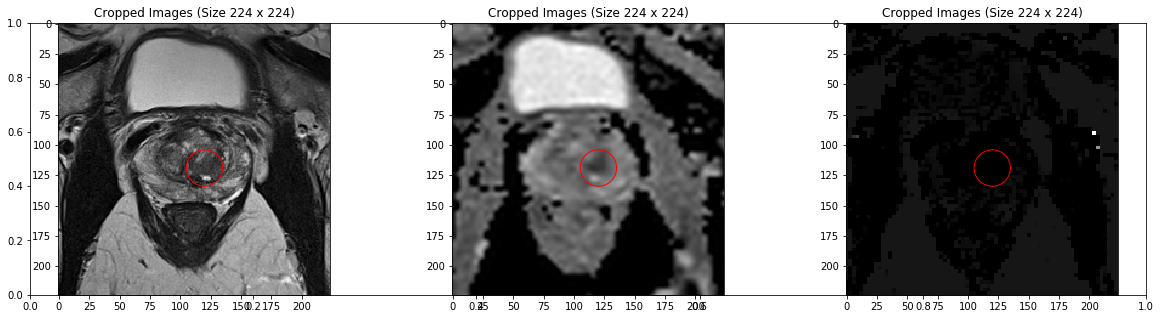

Finding  264
pt_0170
Tumour location: 214 212 16
Prostate center: 192 201 16
The finding is:  False


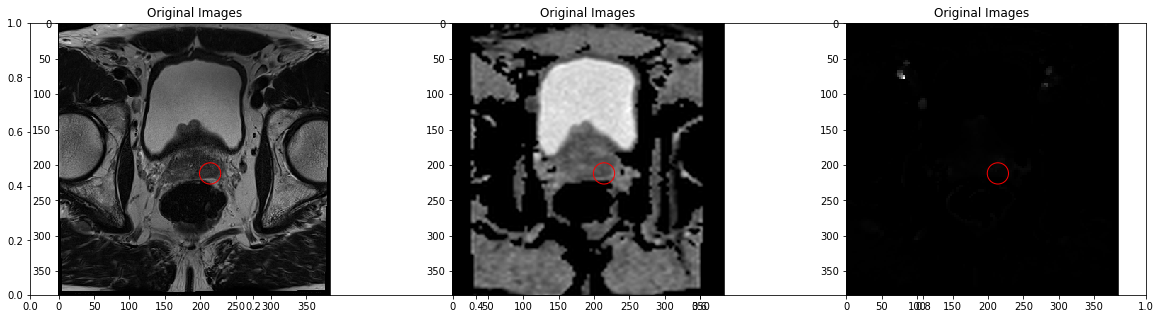

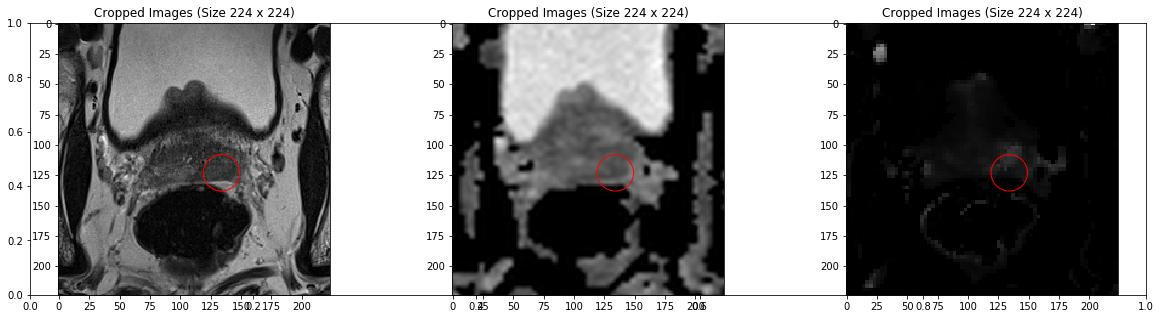

Finding  265
pt_0170
Tumour location: 170 217 13
Prostate center: 193 177 13
The finding is:  False


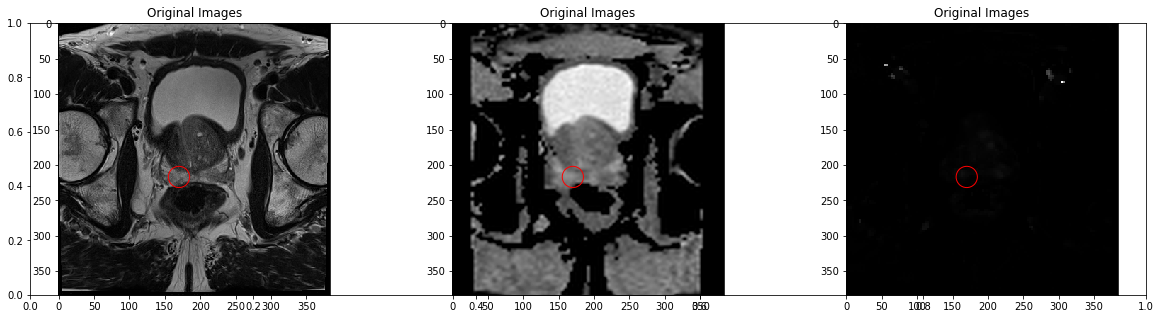

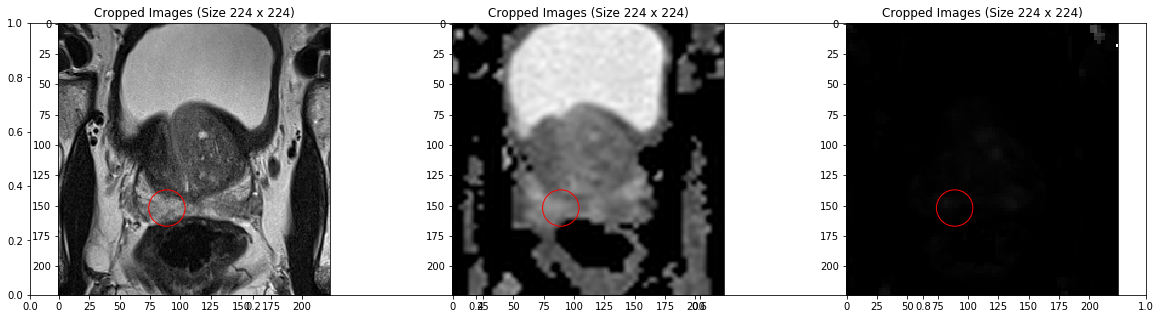

Finding  266
pt_0171
Tumour location: 202 182 10
Prostate center: 191 186 10
The finding is:  False


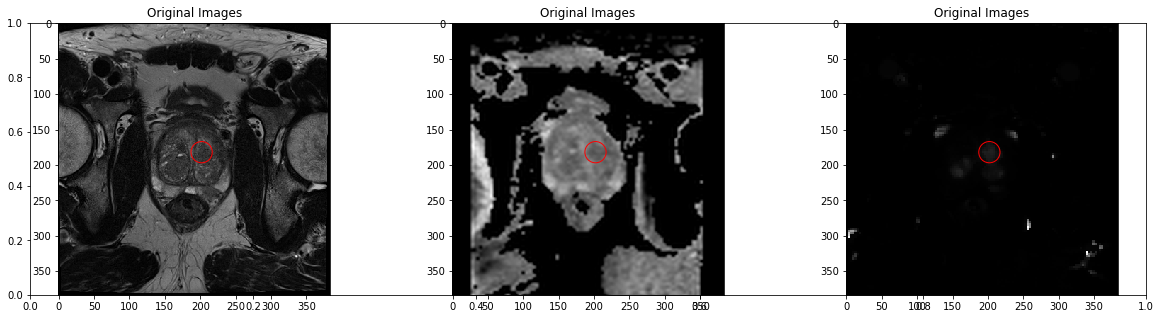

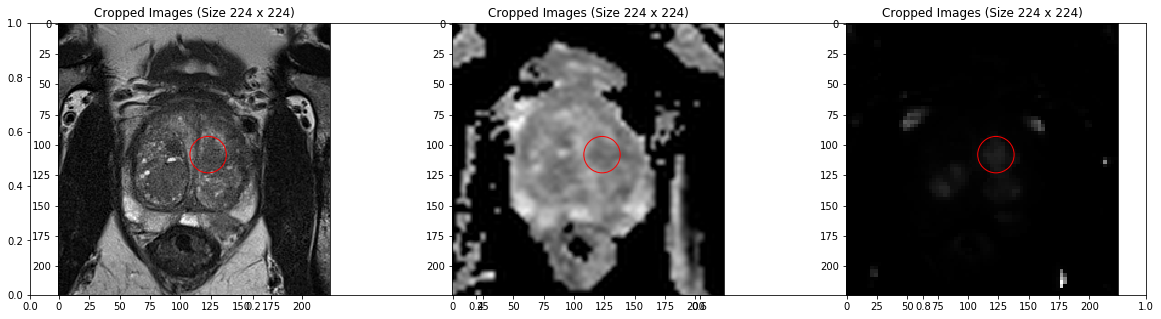

Finding  267
pt_0171
Tumour location: 217 235 11
Prostate center: 188 194 11
The finding is:  False


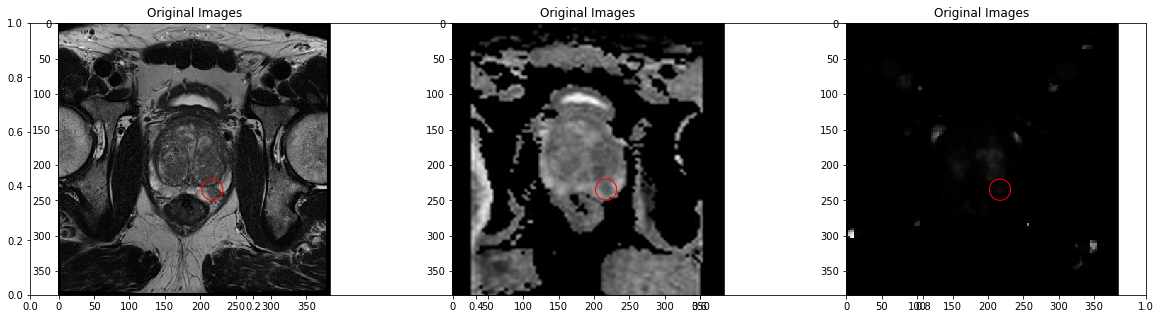

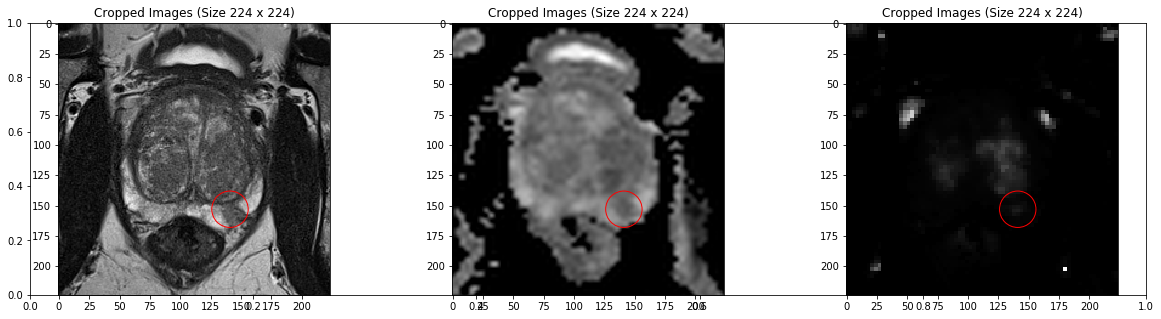

Finding  268
pt_0171
Tumour location: 162 226 11
Prostate center: 188 194 11
The finding is:  False


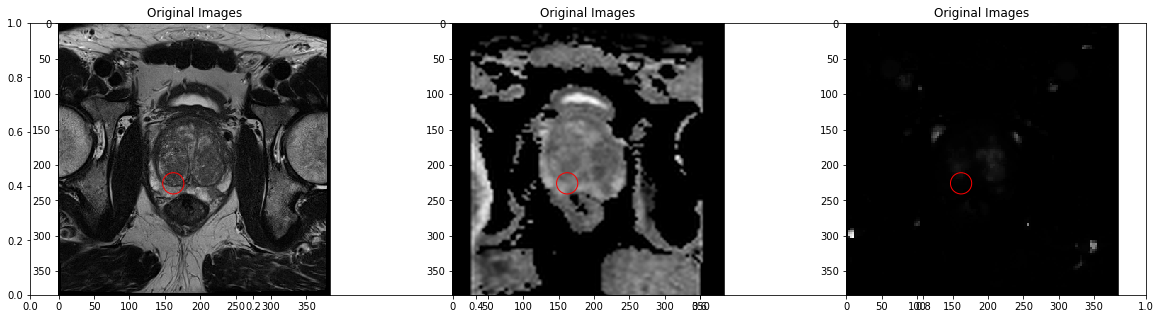

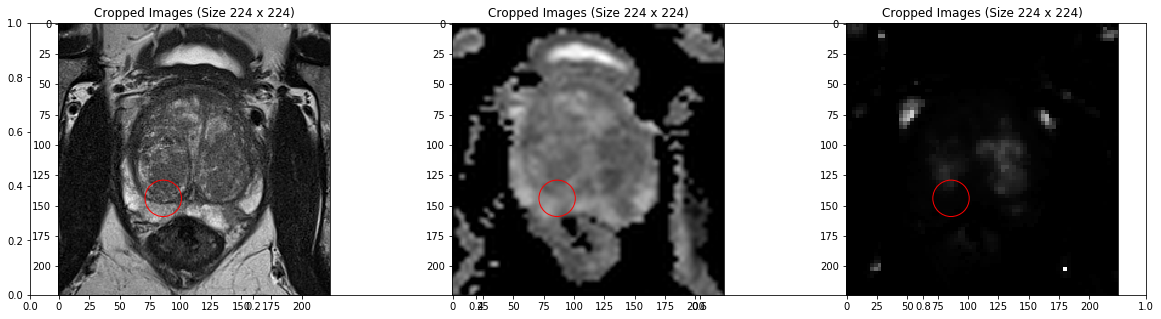

Finding  269
pt_0172
Tumour location: 187 160 3
Prostate center: 191 173 3
The finding is:  False


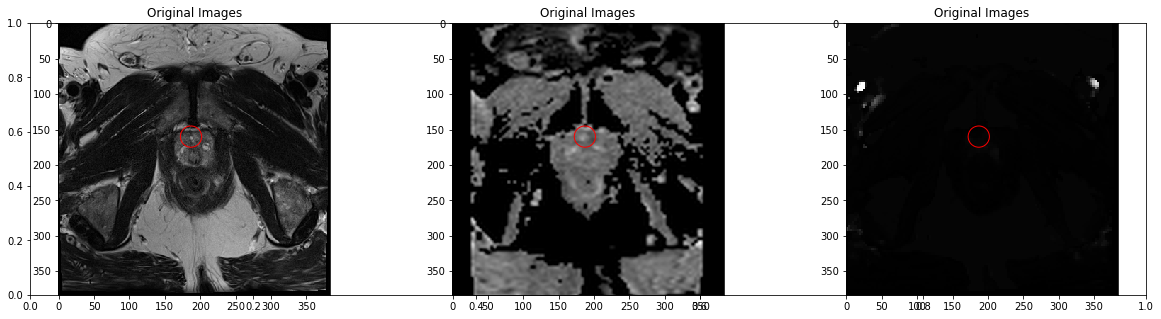

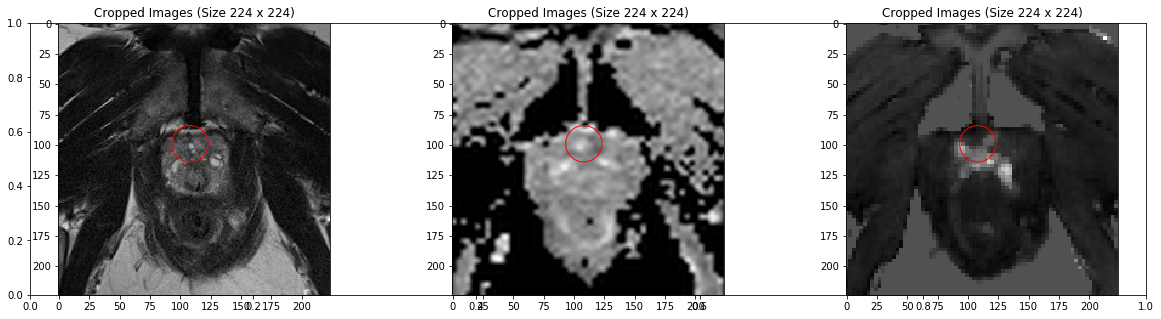

Finding  270
pt_0172
Tumour location: 164 221 10
Prostate center: 200 187 10
The finding is:  False


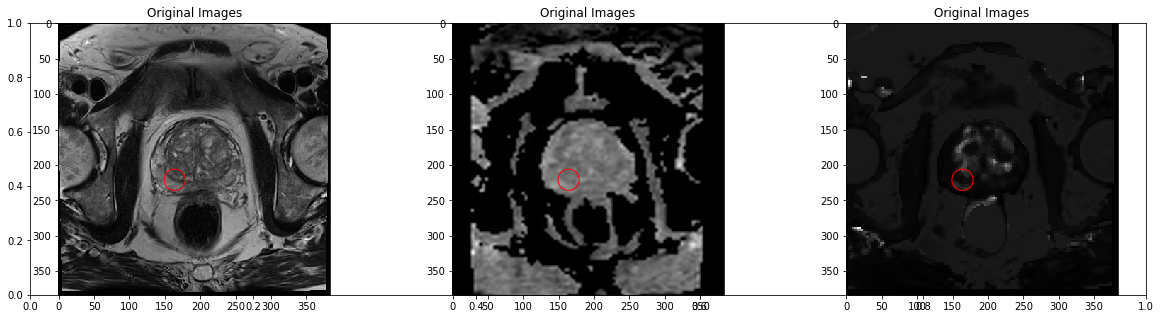

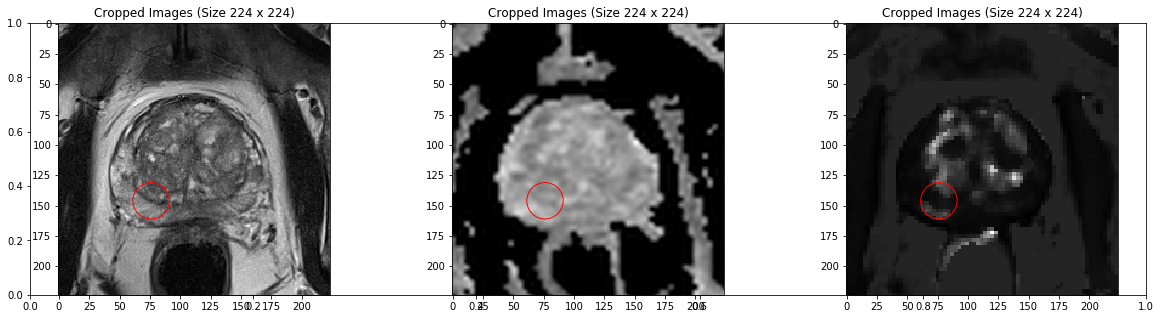

In [10]:
### Display the images of the first 20 patients ###

for j in range (0,10):
    img = stack[j]
    img2 = cstack[j]
    print ('Finding ', str(j+261))
    print (case[j+261])
    print ('Tumour location:', ijk[j+261])
    print ('Prostate center:', proscen[j+261])
    print ('The finding is: ', labels[j+261])
    fig, axes = plt.subplots(figsize=(20,5))
    for i in range (0,3):
        image = img[z[j+261],:,:,i]
        ax1 = fig.add_subplot(1, 3, i+1)
        plt.imshow(image,cmap ='gray')
        circ = Circle((x[j+261],y[j+261]),15, fill=False, color='red')
        ax1.add_patch(circ)
        plt.title('Original Images')
    plt.show()
    fig, axes = plt.subplots(figsize=(20,5))
    for i in range (0,3):
        image2 = img2[:,:,i]
        ax1 = fig.add_subplot(1, 3, i+1)
        plt.imshow(image2,cmap ='gray')
        circ2 = Circle((x[j+261]-X[j+261]+112,y[j+261]-Y[j+261]+112),15, fill=False, color='red')
        ax1.add_patch(circ2)
        plt.title('Cropped Images (Size 224 x 224)')
    plt.show()

In [11]:
import pickle
filename1 = 'fine_tuing_data'
outfile = open(filename1,'wb')
pickle.dump(cstack ,outfile)
pickle.dump(labels[261:] ,outfile)
outfile.close()

In [6]:
import pickle
infile = open('S:\\Usyd\\Project\\Data\\train_data','rb')
Images = pickle.load(infile)
Labels = pickle.load(infile)
infile.close()

In [7]:
print(len(Images), len(Labels), len(Patientid))

196 196 196


In [11]:
arrs = [np.random.random((32, 32, 3))
        for i in range(50)]

res = np.concatenate([arr[np.newaxis] for arr in arrs])
res.shape

(50, 32, 32, 3)

In [15]:
arrs[0].shape

(32, 32, 3)